# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [212]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation, linear_model, metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Lasso

Чтение данных, кодирование категориальных признаков

In [213]:
data_train = pd.read_csv('orange_small_churn_train_data.csv', sep=",", index_col=False)

In [214]:
data_train.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


In [5]:
#категориальные признаки
columns_cat = ['Var'+str(i) for i in range(191, 231)]
data2_cat = data_train[columns_cat]
data2_cat = data2_cat.fillna(value='-')

In [6]:
#кодирование категориальных признаков
%time data2_cat_coded = data2_cat[columns_cat].apply(LabelEncoder().fit_transform)

Wall time: 738 ms


In [7]:
data2_cat_coded.head()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,0,160,5,0,22,0,1,1961,1236,0,...,0,3696,1,0,0,14,0,29,0,0
1,0,169,0,0,22,0,127,743,3521,3020,...,4,347,1,0,1,22,2,2,2,0
2,0,115,17,0,22,0,111,2693,3463,0,...,6,2498,1,0,0,7,3,25,2,0
3,0,329,25,0,22,0,3,3619,1543,0,...,4,2602,1,0,0,22,2,8,0,0
4,0,39,25,0,22,0,206,3005,2496,0,...,4,1375,1,0,0,12,2,8,0,0


In [8]:
#числовые признаки
columns_num = ['Var'+str(i) for i in range(1, 191)]
data2_num = data_train[columns_num]
data2_num = data2_num.fillna(value=0.0)

In [9]:
#нормализация числовых признаков
scaler = StandardScaler()
data2_num_train_data_scaled = scaler.fit_transform(data2_num, data_train['labels'])

In [10]:
#объединение категориальных и числовых признаков
data2_train_X = np.hstack((data2_num_train_data_scaled,data2_cat_coded.as_matrix()))

In [11]:
data2_train_y = data_train['labels'].as_matrix()

In [21]:
%%time
#Будем использовать sklearn.model_selection.learning_curve чтобы оценить зависимость качетсва модели от объема выборки
#Для кросс-валидации используем 5 фолдов, стандартный вариант использует StratifiedKFold
#Размер выборки с шагом 10%
train_sizes = np.arange(0.1, 1.1, 0.1)
curve_1 = learning_curve(LogisticRegression(), data2_train_X, data2_train_y, train_sizes=train_sizes, cv=5, n_jobs=-1) 

Wall time: 2min 32s


In [22]:
curve_1_mean = [folds.mean() for folds in curve_1[1]]
curve_1_mean

[0.92091278524538933,
 0.92558212220659475,
 0.9233253463902491,
 0.92493163528400646,
 0.92443277704856563,
 0.92477733215271629,
 0.92520201794722978,
 0.92456736591273092,
 0.92471266363415394,
 0.9256414262945718]

In [14]:
%%time
#попробуем провести оценку с использованием бустинга
curve_2 = learning_curve(GradientBoostingClassifier(), data2_train_X, data2_train_y, train_sizes=train_sizes, cv=5, n_jobs=-1) 

Wall time: 7min 5s


In [23]:
curve_2_mean = [folds.mean() for folds in curve_2[1]]
curve_2_mean

[0.9364176305095343,
 0.9319893733395842,
 0.92782581518908214,
 0.92833815141807963,
 0.92810800675042204,
 0.92758997864472104,
 0.92774677440957176,
 0.92684870502754024,
 0.92669884370985112,
 0.92746023313228554]

In [15]:
%%time
#попробуем провести оценку с использованием бустинга на маленьких объемах данных
train_sizes_21 = np.arange(0.01, 0.11, 0.01)
curve_21 = learning_curve(GradientBoostingClassifier(), data2_train_X, data2_train_y, train_sizes=train_sizes_21, cv=5, n_jobs=-1) 

Wall time: 27.3 s


In [24]:
curve_21_mean = [folds.mean() for folds in curve_21[1]]
curve_21_mean

[0.99937304075235112,
 0.97715179968701094,
 0.95891553701772703,
 0.95355746677091491,
 0.95184490306441527,
 0.94351224596143823,
 0.94041983028137555,
 0.9387260648690896,
 0.93671413685307403,
 0.93679274773366683]

Кривые обучения для LogisticRegression(синий график) и GradientBoostingClassifier (красный график)

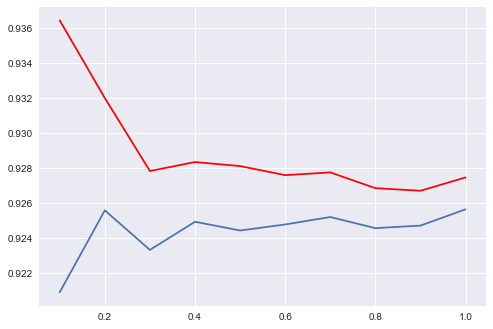

In [25]:
plt.plot(train_sizes, curve_1_mean)
plt.plot(train_sizes, curve_2_mean, color='r')
plt.show()

Видно, что качество модели градиентного бустинга является хорошим уже на 10% выборки и в дальнейшем даже несколько уменьшается.

Исследуем модель градиентного бустинга на малых объемах выборки от 1% до 10%.

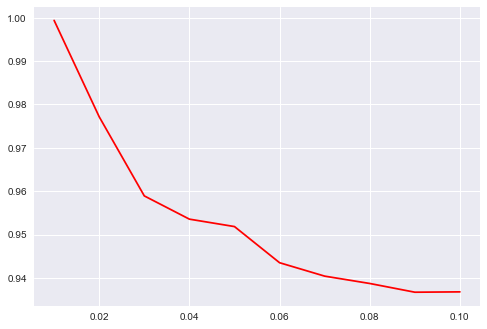

In [26]:
plt.plot(train_sizes_21, curve_21_mean, color='r')
plt.show()

Полученный результат довольно трудно объяснить - на 1% выборке качество наилучшее, в дальнейшем оно уменьшается.

Возьмем за оптимальный объем выборки в 20%, так как после 20% качество обучения в модели LogisticRegression  уменьшается, далее колеблется. Качество обучения на 20% примерно соответствует качеству обучения на 100%.

С помощью функции train_test_split, которая сохраняет баланс классов, отделим 20% выборки для дальнейших экспериментов.

In [33]:
(X_train_20, X_test_20, y_train_20, y_test_20) = train_test_split(data2_train_X, data2_train_y, test_size=0.8, random_state=0)

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

С помощью параметра class_weight можно изменять веса объектов. Стандартный параметр "balanced" использует для расчета формулу n_samples / (n_classes * np.bincount(y)). Расчитаем ее вручную, чтобы определить веса объектов.

In [41]:
data2_train_y_1 = [0 if x==-1 else x for x in y_train_20]
8000.0 / (2.0 * np.bincount(data2_train_y_1))

array([ 0.54097917,  6.60066007])

In [42]:
def ScoreModel(model, X, y):
    print "Модель:"
    print model
    # cross_val_score использует необходимую стратегию StratifiedKFold
    # For integer/None inputs, if the estimator is a classifier 
    # and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.

    roc_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print "roc_auc=%.2f." % (roc_auc.mean())

In [44]:
%%time
#Расчитаем модель с параметром balanced (вариант 1 из 3)
ScoreModel(LogisticRegression(class_weight='balanced'), X_train_20, y_train_20)

Модель:
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
roc_auc=0.63.
Wall time: 1min 15s


In [45]:
%%time
#по сравнению с balanced уменьшим вес второго класса в 2 раза (вариант 2 из 3)
class_weight_2 = {-1:0.54, 1:3.3}
ScoreModel(LogisticRegression(class_weight=class_weight_2), data2_train_X, data2_train_y)

Модель:
LogisticRegression(C=1.0, class_weight={1: 3.3, -1: 0.54}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
roc_auc=0.66.
Wall time: 2min 16s


In [47]:
%%time
#по сравнению с balanced увеличим вес второго класса в 2 раза (вариант 3 из 3)
class_weight_2 = {-1:0.54, 1:13.2}
ScoreModel(LogisticRegression(class_weight=class_weight_2), data2_train_X, data2_train_y)

Модель:
LogisticRegression(C=1.0, class_weight={1: 13.2, -1: 0.54}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
roc_auc=0.65.
Wall time: 2min 45s


Вывод. class_weight='balanced' дает примемлемый результат по качеству. Уменьшение меньшего класса в 2 раза по сравнению с balanced дает несколько лучший вариант (на 3%). Увеличение меньшего класса в 2 раза по сравнению с balanced дает несколько лучший вариант (на 2%). В целом можно сказать что балансировка в 2 раза по сравнению с balanced почти не влияет на качество модели (разница в 2 и 3 %).

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [51]:
X_minus = X_train_20[y_train_20 == -1]

In [52]:
X_minus.shape

(7394L, 230L)

In [53]:
X_plus = X_train_20[y_train_20 == 1]

In [68]:
#размер выборки меньшего класса
X_plus_size = int(X_plus.shape[0])
X_plus_size

606

In [65]:
y_plus = np.array([1] * X_plus.shape[0], dtype=np.int64)

In [66]:
y_plus.shape

(606L,)

In [73]:
#Вариант 1. Размеры большего и меньшего класса одинаковы
X_minus_1 = X_minus[:X_plus_size]
X_minus_1.shape

(606L, 230L)

In [74]:
y_minus_1 = np.array([-1] * X_minus_1.shape[0], dtype=np.int64)
y_minus_1.shape

(606L,)

In [76]:
train_X_minus_1 = np.vstack((X_minus_1, X_plus))
train_X_minus_1.shape

(1212L, 230L)

In [79]:
train_y_minus_1 = np.concatenate((y_minus_1, y_plus))
train_y_minus_1.shape

(1212L,)

In [84]:
%%time
ScoreModel(LogisticRegression(), train_X_minus_1, train_y_minus_1)

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.65.
Wall time: 3.53 s


In [86]:
#Вариант 2. Размер большего класса в 2 раза больше размера меньшего класса
X_minus_2 = X_minus[:X_plus_size*2]
X_minus_2.shape

(1212L, 230L)

In [87]:
y_minus_2 = np.array([-1] * X_minus_2.shape[0], dtype=np.int64)
y_minus_2.shape

(1212L,)

In [88]:
train_X_minus_2 = np.vstack((X_minus_2, X_plus))
train_X_minus_2.shape

(1818L, 230L)

In [89]:
train_y_minus_2 = np.concatenate((y_minus_2, y_plus))
train_y_minus_2.shape

(1818L,)

In [90]:
%%time
ScoreModel(LogisticRegression(), train_X_minus_2, train_y_minus_2)

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.63.
Wall time: 4.63 s


In [91]:
#Вариант 3. Размер большего класса в 3 раза больше размера меньшего класса
X_minus_3 = X_minus[:X_plus_size*3]
X_minus_3.shape

(1818L, 230L)

In [92]:
y_minus_3 = np.array([-1] * X_minus_3.shape[0], dtype=np.int64)
y_minus_3.shape

(1818L,)

In [93]:
train_X_minus_3 = np.vstack((X_minus_3, X_plus))
train_X_minus_3.shape

(2424L, 230L)

In [94]:
train_y_minus_3 = np.concatenate((y_minus_3, y_plus))
train_y_minus_3.shape

(2424L,)

In [95]:
%%time
ScoreModel(LogisticRegression(), train_X_minus_3, train_y_minus_3)

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.64.
Wall time: 5.08 s


Вывод. При использовании размеров классов 1:1 качество около 65%. При увеличении размеров большей выборки в 2 или 3 раза качество падает на 1-2%. В целом можно сделать вывод что undersampling не оказывает существенного влияния на качество модели.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

В этом пункте будем рассматривать регрессию только на числовых признаках.

In [100]:
#числовые признаки
columns_num = ['Var'+str(i) for i in range(1, 191)]
p3_data_num = data_train[columns_num]
p3_data_num.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
#Вариант 1. Заполнение нулями
p3_data_num_zero = p3_data_num.fillna(0.0)
p3_data_num_zero.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190
0,0.0,0.0,0.0,0.0,0.0,3052.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1813.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,276.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1953.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1533.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,686.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
%%time
ScoreModel(LogisticRegression(), p3_data_num_zero, data_train['labels'])

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.54.
Wall time: 53.2 s


In [112]:
#Вариант 2. Заполнение средними значениями
p3_data_num_mean = p3_data_num.fillna(p3_data_num.mean(axis=0))
#по некоторым колонкам не вычисляются значения
p3_data_num_mean = p3_data_num_mean.fillna(0.0)
p3_data_num_mean.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190
0,11.003509,0.00497,429.328358,0.148235,249055.515021,3052.0,6.792126,0.0,47.487719,381346.56309,...,0.0,1.401428e+06,80676.574553,7.419483,0.0,3.515789,16.05614,165.10831,270.585523,22637.159019
1,11.003509,0.00497,429.328358,0.148235,249055.515021,1813.0,7.000000,0.0,47.487719,381346.56309,...,0.0,1.401428e+06,80676.574553,7.419483,0.0,3.515789,16.05614,165.10831,276.000000,22637.159019
2,11.003509,0.00497,429.328358,0.148235,249055.515021,1953.0,7.000000,0.0,47.487719,381346.56309,...,0.0,1.401428e+06,80676.574553,7.419483,0.0,3.515789,16.05614,165.10831,270.585523,22637.159019
3,11.003509,0.00497,429.328358,0.148235,249055.515021,1533.0,7.000000,0.0,47.487719,381346.56309,...,0.0,1.401428e+06,80676.574553,7.419483,0.0,3.515789,16.05614,165.10831,270.585523,22637.159019
4,11.003509,0.00497,429.328358,0.148235,249055.515021,686.0,7.000000,0.0,47.487719,381346.56309,...,0.0,1.401428e+06,80676.574553,7.419483,0.0,3.515789,16.05614,165.10831,270.585523,22637.159019


In [113]:
%%time
ScoreModel(LogisticRegression(), p3_data_num_mean, data_train['labels'])

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.59.
Wall time: 4min 9s


In [114]:
#Вариант 3. Заполнение медианами
p3_data_num_median = p3_data_num.fillna(p3_data_num.median(axis=0))
#по некоторым колонкам не вычисляются значения
p3_data_num_median = p3_data_num_median.fillna(0.0)
p3_data_num_median.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190
0,0.0,0.0,0.0,0.0,0.0,3052.0,7.0,0.0,20.0,0.0,...,0.0,108414.0,0.0,0.0,0.0,0.0,4.0,196.41,270.0,12612.24
1,0.0,0.0,0.0,0.0,0.0,1813.0,7.0,0.0,20.0,0.0,...,0.0,108414.0,0.0,0.0,0.0,0.0,4.0,196.41,276.0,12612.24
2,0.0,0.0,0.0,0.0,0.0,1953.0,7.0,0.0,20.0,0.0,...,0.0,108414.0,0.0,0.0,0.0,0.0,4.0,196.41,270.0,12612.24
3,0.0,0.0,0.0,0.0,0.0,1533.0,7.0,0.0,20.0,0.0,...,0.0,108414.0,0.0,0.0,0.0,0.0,4.0,196.41,270.0,12612.24
4,0.0,0.0,0.0,0.0,0.0,686.0,7.0,0.0,20.0,0.0,...,0.0,108414.0,0.0,0.0,0.0,0.0,4.0,196.41,270.0,12612.24


In [115]:
%%time
ScoreModel(LogisticRegression(), p3_data_num_median, data_train['labels'])

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.60.
Wall time: 2min 54s


Вывод. Заполнение средними значениями приводит к лучшему качеству на 4%, чем заполнение нулями. Заполнение медианами на 1% лучше чем заполнение средними. Таким образом, для заполнения лучше использовать средние или медианы, но заполнение нулями не сильно ухудшает качество.

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Для обработки катеогриальных признаков будем использовать 2 подхода - OneHotEncoder, который кодирует категориальную переменную в виде набора бинарных, и LabelEncoder, который кодирует переменную в виде числовых значений.

В этом пункте будем рассматривать регрессию только на категориальных признаках.

In [116]:
#категориальные признаки
columns_cat = ['Var'+str(i) for i in range(191, 231)]
p4_data_cat = data_train[columns_cat]
p4_data_cat = p4_data_cat.fillna(value='-')
p4_data_cat.head()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,-,NESt0G8EIb,AERks4l,-,taul,1K8T,0LaQ,UaKK0yW,I1sFbv_0IT,-,...,Al6ZaUT,vr93T2a,LM8l689qOp,-,-,fKCe,02N6s8f,xwM2aC7IdeMC0,-,-
1,-,P1WvyxLp3Z,2Knk1KF,-,taul,1K8T,YFAj,Bnunsla,o64y9zI,DlISMzi,...,oslk,6hQ9lNX,LM8l689qOp,-,ELof,xb3V,RAYp,55YFVY9,mj86,-
2,-,FoxgUHSK8h,LrdZy8QqgUfkVShG,-,taul,1K8T,TyGl,fhk21Ss,nQUveAzAF7,-,...,zCkv,catzS2D,LM8l689qOp,-,-,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,-
3,-,vNEvyxLp3Z,RO12,-,taul,1K8T,0Xwj,uoZk2Zj,LWyxgtXeJL,-,...,oslk,e4lqvY0,LM8l689qOp,-,-,xb3V,RAYp,F2FyR07IdsN7I,-,-
4,-,4e7gUH7IEC,RO12,-,taul,1K8T,vSNn,kugYdIL,ZIXKpoNpqq,-,...,oslk,MAz3HNj,LM8l689qOp,-,-,WqMG,RAYp,F2FyR07IdsN7I,-,-


In [125]:
%%time
#Вариант 1. Кодирование категориальных признаков с помощью OneHotEncoder
p4_data_cat_OneHotEncoder = pd.get_dummies(p4_data_cat)

Wall time: 34.1 s


In [126]:
p4_data_cat_OneHotEncoder.head()

,Var191_-,Var191_r__I,Var192_-,Var192_0G9vyxdMWg,Var192_0kQTmBU3gb,Var192_0kQqrQsiZt,Var192_0vimfo8zhV,Var192_1GdOj17ejg,Var192_1GdOj1KXzC,Var192_1JGTmBQZiT,...,Var228_iyHGyLCEkQ,Var228_n1OBWGkV3fbsHR75taC,Var228_r_7E,Var228_xwM2aC7IdeMC0,Var229_-,Var229_am7c,Var229_mj86,Var229_oJmt,Var229_sk2h,Var230_-
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [127]:
%%time
ScoreModel(LogisticRegression(), p4_data_cat_OneHotEncoder, data_train['labels'])

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.63.
Wall time: 6min 55s


In [118]:
%%time
#Вариант 2. Кодирование категориальных признаков с помощью LabelEncoder
p4_data_cat_LabelEncoder = p4_data_cat.apply(LabelEncoder().fit_transform)

Wall time: 696 ms


In [119]:
p4_data_cat_LabelEncoder.head()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,0,160,5,0,22,0,1,1961,1236,0,...,0,3696,1,0,0,14,0,29,0,0
1,0,169,0,0,22,0,127,743,3521,3020,...,4,347,1,0,1,22,2,2,2,0
2,0,115,17,0,22,0,111,2693,3463,0,...,6,2498,1,0,0,7,3,25,2,0
3,0,329,25,0,22,0,3,3619,1543,0,...,4,2602,1,0,0,22,2,8,0,0
4,0,39,25,0,22,0,206,3005,2496,0,...,4,1375,1,0,0,12,2,8,0,0


In [121]:
%%time
ScoreModel(LogisticRegression(), p4_data_cat_LabelEncoder, data_train['labels'])

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.63.
Wall time: 17.2 s


In [215]:
#Вариант 3. Кодирование категориальных признаков с помощью LabelEncoder без замены пустых значений
columns_cat = ['Var'+str(i) for i in range(191, 231)]
p4_data_cat_na = data_train[columns_cat]
p4_data_cat_na.head()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NESt0G8EIb,AERks4l,NaN,taul,1K8T,0LaQ,UaKK0yW,I1sFbv_0IT,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,P1WvyxLp3Z,2Knk1KF,NaN,taul,1K8T,YFAj,Bnunsla,o64y9zI,DlISMzi,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,FoxgUHSK8h,LrdZy8QqgUfkVShG,NaN,taul,1K8T,TyGl,fhk21Ss,nQUveAzAF7,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,vNEvyxLp3Z,RO12,NaN,taul,1K8T,0Xwj,uoZk2Zj,LWyxgtXeJL,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,4e7gUH7IEC,RO12,NaN,taul,1K8T,vSNn,kugYdIL,ZIXKpoNpqq,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN


In [216]:
%%time
p4_data_cat_na_LabelEncoder = p4_data_cat_na.apply(LabelEncoder().fit_transform)

C:\ProgramData\Anaconda2\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


Wall time: 1.12 s


In [217]:
%%time
ScoreModel(LogisticRegression(), p4_data_cat_na_LabelEncoder, data_train['labels'])

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.57.
Wall time: 11.9 s


Вывод. Использование OneHotEncoder генерирует датасет с очень большим количеством бинарных колонок, что очень увеличивает время построения модели. При этом LabelEncoder и OneHotEncoder обеспечивают одинаковое качество модели - в проведенном эксперименте около 63%. Если использовать LabelEncoder без замены пустых значений, то качество ухудшается -  57%.

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

**Вариант 1.** Модуль sklearn.feature_selection обеспечивает подбор признаков. Воспользуемся функцией SelectKBest которая обеспечивает  выбор К лучших признаков. Возьмем К = 30. В качестве датасета возьмем исходный, в котором категориальные признаки закодированы с помощью LabelEncoder и припущенные значения заменены нулями.

In [130]:
%%time
selector = SelectKBest(k=30)
#Метод отбирает лучшие признаки
data2_train_X_SelectKBest = selector.fit_transform(data2_train_X, data2_train_y)

Wall time: 267 ms


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  7  14  19  30  31  38  41  47  51  54  78 140 166 168 174 184 208 229] are constant.
  UserWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [131]:
data2_train_X_SelectKBest.shape

(40000L, 30L)

In [132]:
%%time
ScoreModel(LogisticRegression(), data2_train_X_SelectKBest, data2_train_y)

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.66.
Wall time: 5.69 s


**Вариант 2. ** sklearn.linear_model.Lasso обеспечивает отбор признаков с помощью l1-регуляризации. 

In [133]:
%%time
lasso = Lasso()
lasso.fit(data2_train_X, data2_train_y)

Wall time: 247 ms


In [136]:
#линейно-зависимые признаки
cols_to_delete = [i for i,x in enumerate(lasso.coef_) if lasso.coef_[i] == 0.0]

In [142]:
#количество признаков, которые оставил Lasso
int(data2_train_X.shape[1]) - len(cols_to_delete)

9

In [143]:
#удалим линейно-зависимые признаки
data2_train_X_fs = np.delete(data2_train_X,cols_to_delete,axis=1)

In [145]:
%%time
ScoreModel(LogisticRegression(), data2_train_X_fs, data2_train_y)

Модель:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.53.
Wall time: 429 ms


Вывод. Использование метода SelectKBest для отбора признаков дает качество 66%, что по крайней мере не ухудшает предыдущие результаты. Использование Lasso дает очень низкое качество 53%.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

С использованием `sklearn.model_selection.GridSearchCV` проведем подбор параметров по сетке.

In [200]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

In [201]:
optimizer = GridSearchCV(LogisticRegression(), param_grid, cv=3)
optimizer.fit(X_train_20, y_train_20)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [203]:
#Лучшие подобранные параметры
optimizer.best_params_

{'C': 0.01}

Вывод. Параметр С отвечает за регуляризацию модели, значение 0.01 означает сильную регуляризацию.

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

Воспользуемся свойством `feature_importances_` для градиентного бустинга. Методика состоит в том, что чем больше значение      `feature_importances_` тем больше вклад признака в модель.

In [146]:
%%time
#Воспользуемся свойством feature_importances_ для градиентного бустинга
model_fi = GradientBoostingClassifier()
model_fi.fit(data2_train_X, data2_train_y)

Wall time: 26.4 s


In [179]:
#Сумма всех коэффициентов равна 1
sum(model_fi.feature_importances_)

1.0

In [150]:
#Пересчитаем вклад в процентах
fi = [(i,x) for i,x in enumerate(model_fi.feature_importances_)]
fi_ord = sorted(fi, key=lambda x: -x[1])

In [160]:
fi_ord_proc = [(i, round(x*100.0,2)) for i,x in fi_ord]
fi_ord_proc_x = range(1, 231)
fi_ord_proc_num = [i for i,x in fi_ord_proc]
fi_ord_proc_y = [x for i,x in fi_ord_proc]

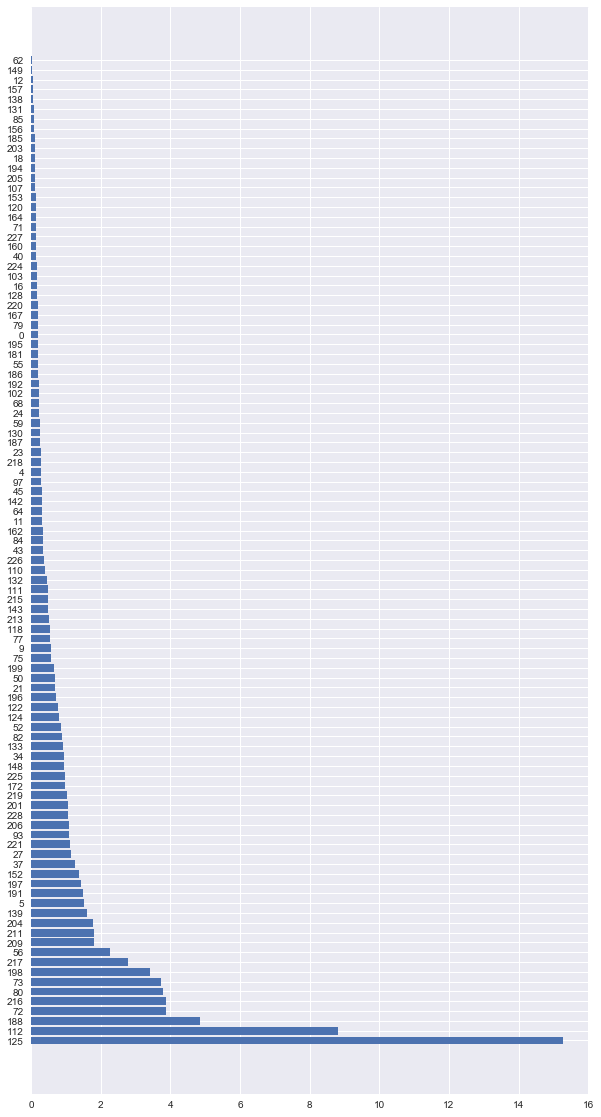

In [178]:
#построим график по ненулевым признакам
plt.figure(figsize=(10,20))
plt.barh(fi_ord_proc_x[:101], fi_ord_proc_y[:101])
plt.yticks(fi_ord_proc_x[:101], fi_ord_proc_num[:101])
plt.show()

Вывод. Оценен вклад каждого признака в %.

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [183]:
#Найдем вероятности принадлежности к классам с помощью LogisticRegression
p8_regr = LogisticRegression()
p8_regr.fit(data2_train_X, data2_train_y)
p8_regr_proba = p8_regr.predict_proba(data2_train_X)

In [191]:
data_train_proba = data_train.copy()
data_train_proba['p0'] = p8_regr_proba[:,0]
data_train_proba['p1'] = p8_regr_proba[:,1]

In [198]:
#объекты, которые ошибочно отнесены к неоттоку
data_train_proba[(data_train_proba['labels']==1) & (data_train_proba['p1']<0.3)]

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels,p0,p1
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.918078,0.081922
29,29,NaN,NaN,NaN,NaN,NaN,252.0,0.0,NaN,NaN,...,NaN,NaN,3Cy4,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.907011,0.092989
49,49,NaN,NaN,NaN,NaN,NaN,5859.0,7.0,NaN,NaN,...,NaN,NaN,szEZ,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.885122,0.114878
69,69,NaN,NaN,NaN,NaN,NaN,1078.0,0.0,NaN,NaN,...,NaN,NaN,rgKb,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.929057,0.070943
71,71,NaN,NaN,NaN,NaN,NaN,154.0,0.0,NaN,NaN,...,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.866629,0.133371
83,83,NaN,NaN,NaN,NaN,NaN,2037.0,14.0,NaN,NaN,...,NaN,NaN,7P5s,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,NaN,NaN,1,0.944372,0.055628
86,86,NaN,NaN,NaN,NaN,NaN,1449.0,7.0,NaN,NaN,...,NaN,kG3k,WqMG,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,1,0.832729,0.167271
90,90,NaN,NaN,NaN,NaN,NaN,308.0,0.0,NaN,NaN,...,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,1,0.786213,0.213787
93,93,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,...,NaN,ELof,453m,6fzt,SbOd7O8ky1wGNxp0Arj0Xs,am7c,NaN,1,0.914245,0.085755
123,123,NaN,NaN,NaN,NaN,NaN,2485.0,0.0,NaN,NaN,...,NaN,kG3k,Xa3G,RAYp,F2FyR07IdsN7I,mj86,NaN,1,0.863025,0.136975


In [199]:
#объекты, которые ошибочно отнесены к оттоку
data_train_proba[(data_train_proba['labels']==-1) & (data_train_proba['p0']<0.3)]

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels,p0,p1
37867,37867,NaN,NaN,NaN,NaN,NaN,28.0,0.0,NaN,NaN,...,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,-1,0.282712,0.717288


Вывод. Большинство этих объектов (строк) характеризуются наличием попущенных значений в большом количестве признаков, что усложняет работу классификатора.

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Для построения финальной модели на основе LogisticRegression будем использовать:
- полную выборку для улучшения качества (хотя результаты экспериментов показали что достаточно 20%)
- веса модели модели менять не будем, undersampling применять не будем, так как они не сильно влияют на качество
- заполнение средними значениями и нормализацию для числовых признаков
- использование LabelEncoder для обработки категориальных признаков
- использование SelectKBest(k=30) для выделения лучших признаков
- подобранные по сетке параметры

In [205]:
#числовые признаки
data_res_num = data_train[columns_num]
data_res_num = data_res_num.fillna(data_res_num.mean(axis=0))
#если для колонки не удалось рассчитать среднее
data_res_num = data_res_num.fillna(0.0)
#нормализация числовых признаков
scaler = StandardScaler()
data_res_num_scaled = scaler.fit_transform(data_res_num, data_train['labels'])
#объединение категориальных и числовых признаков (работа с категориальными признаками выполнена в предыдущих пунктах)
data_res_train_X = np.hstack((data_res_num_scaled,data2_cat_coded.as_matrix()))

In [209]:
%%time
selector = SelectKBest(k=30)
#Метод отбирает лучшие признаки
data_res_train_X_SelectKBest = selector.fit_transform(data_res_train_X, data2_train_y)

Wall time: 189 ms


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  7  14  19  30  31  38  41  47  51  54  78 117 140 166 168 174 184 208
 229] are constant.
  UserWarning)


In [210]:
%%time
#Итоговая модель с параметрами подобранными по сетке
ScoreModel(LogisticRegression(C=0.01), data_res_train_X_SelectKBest, data2_train_y)

Модель:
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
roc_auc=0.67.
Wall time: 4.77 s


Вывод. Качество 67% в целом лучше результатов всех предыдущих экспериментов.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

При построении модели с использованием градиентного бустинга можно использовать свойство `feature_importances_` и удалять признаки с нулевым значением важности. В определенном смысле это напоминает использование Lasso для линейных методов.